# Stem Cell Model

From Brady et al.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from odeModels import StemCellModel, StemCellModel2
from plotUtils import PlotSimulation


In [2]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

## Model Simulations

In [135]:
# Patient 1002 - TTP ~ 3000 days
stemParamDic2 = {'rR': np.log(2),'beta': 0.025, 'dR': 0.4852,  # Cell params
                'rho': 0.0025, 'phi': 0.0167, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 58.57}  # Initial conditions
# Patient 1005 - TTP ~ 3000 days
stemParamDic5 = {'rR': np.log(2),'beta': 0.0276, 'dR': 0.3205,  # Cell params
                'rho': 0.0016, 'phi': 0.0068, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 95.86}  # Initial conditions
# Patient 1010 - TTP ~ 300 days
stemParamDic10 = {'rR': np.log(2),'beta': 0.3332, 'dR': 0.0958,  # Cell params
                'rho': 6.548e-5, 'phi': 0.0028, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 17.33}  # Initial conditions
# Patient 1014 - TTP ~ 2000 days
stemParamDic14 = {'rR': np.log(2),'beta': 0.0425, 'dR': 0.0478,  # Cell params
                'rho': 1.243e-04, 'phi': 0.0113, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 11.83}  # Initial conditions
# Patient 1018 - TTP ~ 800 days
stemParamDic18 = {'rR': np.log(2),'beta': 0.1208, 'dR': 0.2083,  # Cell params
                'rho': 4.931e-04, 'phi': 0.0149, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 36.54}  # Initial conditions

Mean TTP for Stem Cell Model under Continuous Therapy is 1099 days


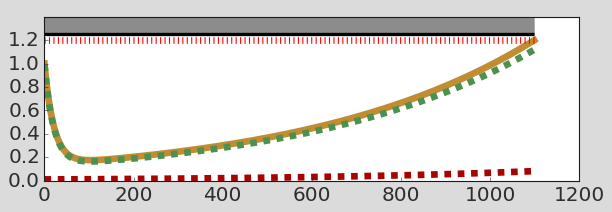

In [136]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
stemParamDic['P0'] = 0; stemParamDic['rho'] = 0; stemParamDic['phi'] = 0

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

Mean TTP for Stem Cell Model under Continuous Therapy is 2238 days


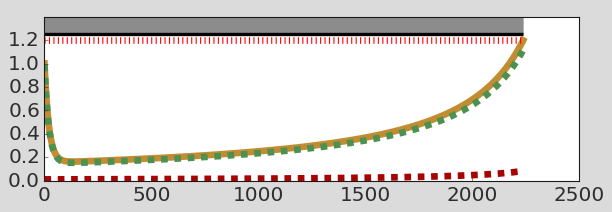

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

model = StemCellModel2(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

In [31]:
def synthetic_R_pop(t, beta, rR, N_star, N0, R0, **kwargs):
    return R0 / (1 - beta * rR * (2 * R0 / (N_star + N0)) * t)

def synthetic_S_pop(t, beta, rR, N_star, N0, R0, **kwargs):
    bracket = 1 - beta * rR * t * (2 * R0 / (N_star + N0))
    return N0 * (1 - np.log(bracket) / beta)


Mean TTP for Stem Cell Model under Continuous Therapy is 27 days


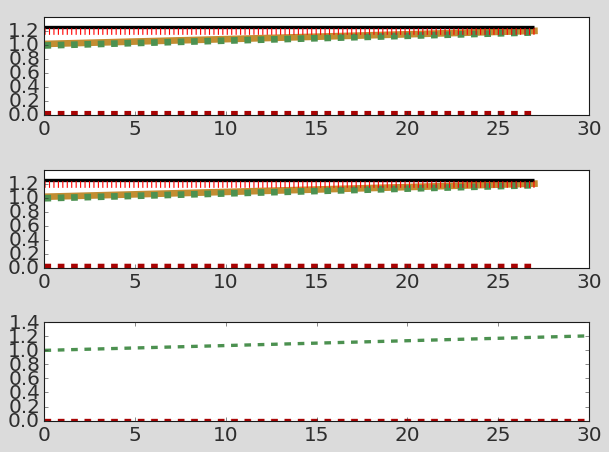

In [35]:
fig, axs = plt.subplots(3,1,figsize=(8,6))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}

for i, modelclass in enumerate([StemCellModel, StemCellModel2]):
    model = modelclass(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    # model.Simulate([[0, 3000, 1]])
    model.Simulate_AT(atThreshold=2, intervalLength=1, t_end=10000)
    # model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]
    
    PlotSimulation(model.resultsDf, ax=axs[i], legend=False, colors = palette, linewidth = 6)

t_span = np.linspace(0, axs[1].get_xlim(), 100) 
axs[2].plot(t_span, synthetic_R_pop(t_span, N_star=stemParamDic['N0'], **stemParamDic)/stemParamDic['N0'], color=colors['Resistant'], linestyle='--', linewidth=3)
axs[2].plot(t_span, synthetic_S_pop(t_span, N_star=stemParamDic['N0'], **stemParamDic)/stemParamDic['N0'], color=colors['Sensitive'], linestyle='--', linewidth=3)

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")


In [42]:
# Can the analytic expression predict the progression threshold from the initial size and growth time
# Does the solver then correctly extract this time given the progression threshold and initial size?

print(synthetic_S_pop(30, N_star=stemParamDic['N0'], **stemParamDic) / stemParamDic['N0'])

1.2067913514889557


In [43]:
from scipy.optimize import fsolve

def N_star_wrapper(N_star):
    return N_star_function(N_star, tau=30, **stemParamDic)

def N_star_function(N_star, tau, rR, beta, R0, N0,  **_args):
    bracket = 1 - beta * rR * tau * (2 * R0 / (N_star + N0))
    print(bracket)
    return 1.2 * N0 - N_star * (1 - np.log(bracket) / beta)


N_star_initial_guess = stemParamDic['N0']
N_star_solution = fsolve(N_star_wrapper, N_star_initial_guess)
print(N_star_solution)

[0.99124987]
[0.99124987]
[0.99124987]
[0.99124987]
[0.99122285]
[0.99122286]
[0.99122286]
[1003.78272578]


Mean TTP for Stem Cell Model under Adaptive Therapy is 2125 days


(0.0, 2500.0)

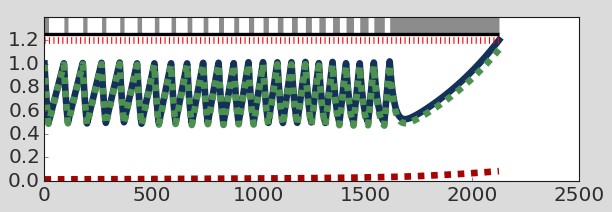

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

ax.set_xlim(0, 2500)

Mean TTP for Stem Cell Model under Adaptive Therapy is 2238 days


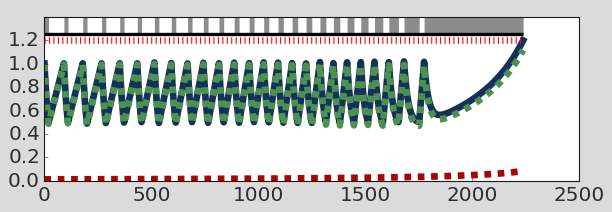

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel2(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

Mean TTP for Stem Cell Model under Adaptive Therapy is 833 days


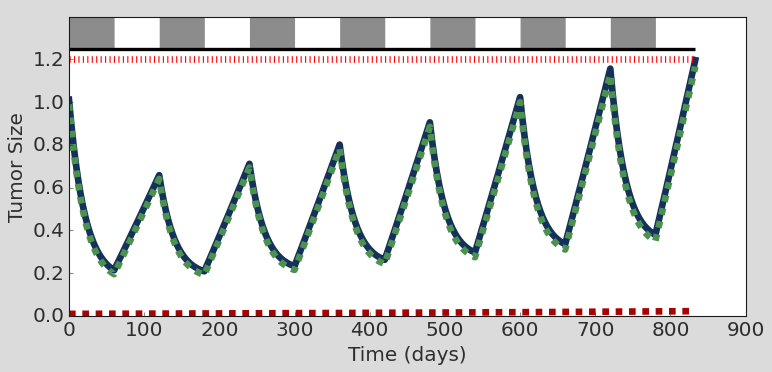

In [55]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.6, atMethod='Threshold',
                    intervalLength=60, t_end=1500, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

plt.xlabel("Time (days)"); plt.ylabel("Tumor Size")
palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
plt.savefig("../figures/stem_cell_model_progression_example")

In [16]:
def calc_ttp(params, n_crit, interval):
    model = StemCellModel(method='Radau', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=n_crit, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

In [118]:
from scipy.optimize import fsolve

def N_star_wrapper(N_star):
    return N_star_function(N_star, tau=4, **stemParamDic)

def N_star_function(N_star, tau, rR, beta, R0, N0,  **_args):
    bracket = 1 - beta * rR * tau * (2 * R0 / (N_star + N0))
    return 1.2 * N0 - N_star * (1 - np.log(bracket) / beta)


N_star_initial_guess = stemParamDic['N0']
N_star_solution = fsolve(N_star_wrapper, N_star_initial_guess)
print(N_star_solution / stemParamDic['N0'])

[1.17037773]


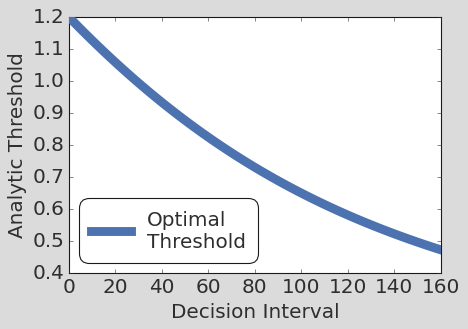

In [119]:
# Plot these, normalising the tumour size by the initial size
fig, ax = plt.subplots(1,1,figsize=(6,4))

tau_values = np.linspace(0, 160, 100)

def solver_wrapper(tau, params):
    inner_wrapper = lambda N_star : N_star_function(N_star, tau=tau, **params)
    return fsolve(inner_wrapper, params['N0'])

n_stars = [solver_wrapper(tau=t, params=stemParamDic) / stemParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

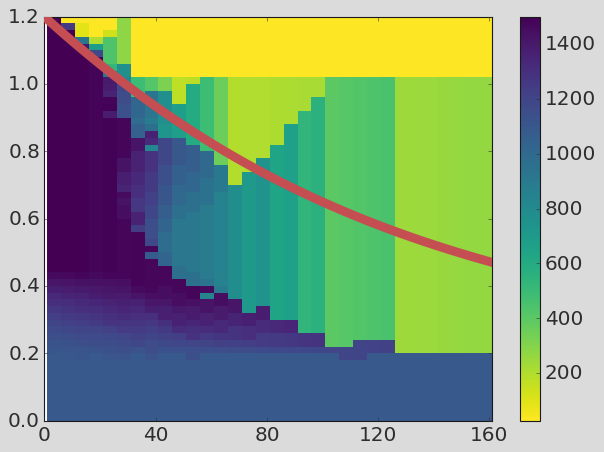

In [50]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator



# make these smaller to increase the resolution
dx, dy = 1, 0.01
dx, dy = 5, 0.02
# dx, dy = 40, 0.4

# generate 2 2d grids for the x & y bounds
crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold"); plt.show()

## Updated Formulation - Exact solution


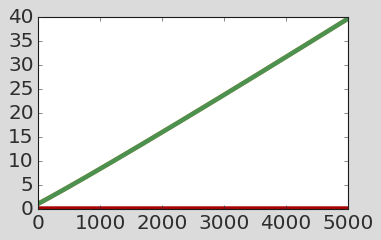

In [161]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate([[0, 5000, 0]])
# model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])

plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, model.resultsDf.S, color=colors['Sensitive'], linewidth=4)
plt.plot(model.resultsDf.Time, model.resultsDf.R, color=colors['Resistant'], linewidth=4)

Okay so this does look pretty linear. But can we predict the gradient?

In [162]:
print(stemParamDic)

{'rR': 0.6931471805599453, 'beta': 0.0425, 'dR': 0.0478, 'rho': 0, 'phi': 0, 'DMax': 1, 'S0': 1000, 'R0': 10, 'P0': 0, 'N0': 1010}


Final y value is 39.57681285


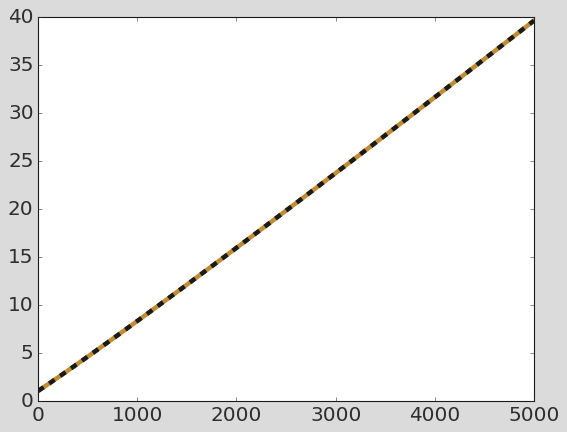

In [163]:
def predict_Nt(t, beta, rR, N0, R0, **kwargs):
    return ((rR * (1 - beta) * R0 * t) / (N0 ** beta) + N0 ** (1-beta) ) ** (1 / (1-beta))

# def simple_predict_Nt(t, beta, rR, N0, R0, **kwargs):
#     return N0 + rR * R0 / (N0 ** beta) * t

y_vals = [predict_Nt(t, **stemParamDic) / stemParamDic['N0'] for t in model.resultsDf.Time.values]
print(f"Final y value is {y_vals[-1]:.8f}")

plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, y_vals, color='k', linestyle='--', linewidth=4);

Final y value is 39.57681285


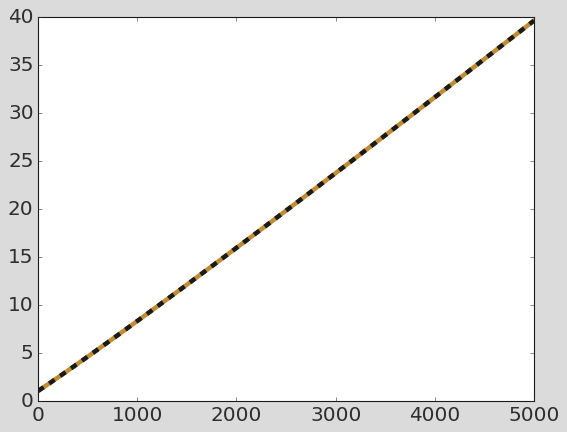

In [165]:
# To check - we can also predict the tumour size from the R population directly

def predict_Nt(R, beta, N0, R0, **kwargs):
    # print((1/ R0) ** (1 / beta))
    return N0 * (R/ R0) ** (1 / beta)

y_vals = [predict_Nt(R , **stemParamDic) / stemParamDic['N0'] for R in model.resultsDf.R.values * stemParamDic['N0'] ]
print(f"Final y value is {y_vals[-1]:.8f}")

# plt.ylim(0, 10)


plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, y_vals, color='k', linestyle='--', linewidth=4);

### Use the new approach for map

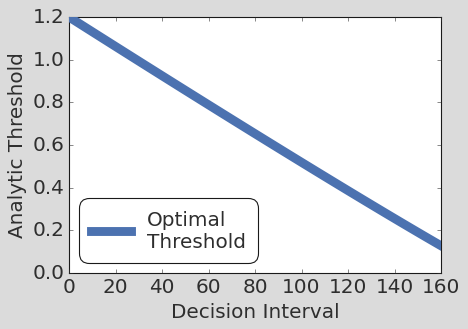

In [166]:
def predict_N_star(tau, beta, rR, N0, R0, **kwargs):
    return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * R0 * tau) / (N0 ** beta) ) ** (1 / (1-beta))

# Plot these, normalising the tumour size by the initial size
fig, ax = plt.subplots(1,1,figsize=(6,4))

new_n_stars = [predict_N_star(tau=t, **stemParamDic) / stemParamDic['N0'] for t in tau_values]
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

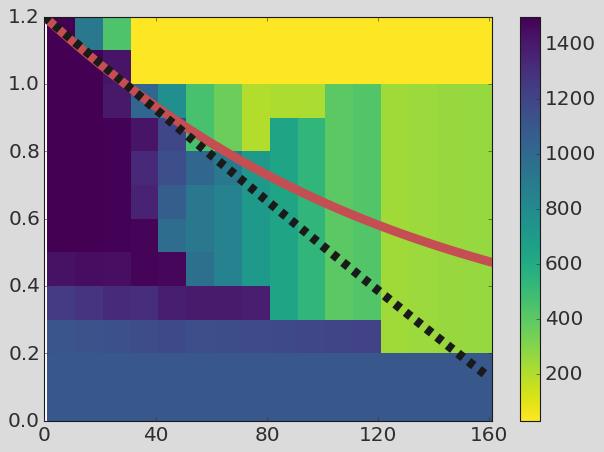

In [137]:
dx, dy = 1, 0.01
dx, dy = 10, 0.1
# dx, dy = 40, 0.4

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Approx\nThreshold'); 
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, color='k', linestyle='--', label = 'Exact\nThreshold');

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold2"); plt.show()


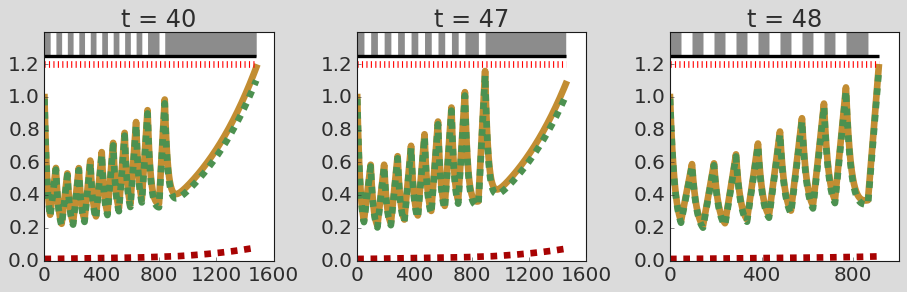

In [155]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [40, 47, 48]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=1500,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")


This doesn't account for growing population of stem cells. It computes the growth in tau time at the start of treatment only. 

When writing this down, we have adjusted the initial conditions of one integral (N over t) to reflect the new starting position, but not the original integral (N over S). In effect, the constant of integration B needs to be time dependent, based on the stem-cell population at that point in time.

We can't compute this exactly, as it depends on the treatment history. But perhaps we can use the previous method for approximating this growth?

## Approach 3

In [167]:
def updated_predict_N_star(tau, t, beta, rR, N0, R0, **kwargs):
    ave_n = (N0 + (1.2 * N0)) / 2
    Rt = R0 / (1 - beta * rR * (R0 / ave_n) * t)
    B_const = (N0 ** beta) / Rt
    return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * tau) / B_const ) ** (1 / (1-beta))

/var/folders/by/xwl2vmrj5dl9941qxr6lr2t4002mml/T/ipykernel_10185/93238832.py:5: RuntimeWarning: invalid value encountered in scalar power
  return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * tau) / B_const ) ** (1 / (1-beta))


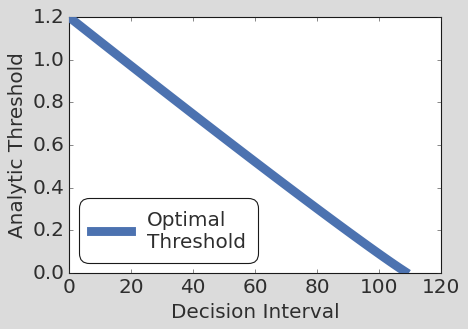

In [173]:

fig, ax = plt.subplots(1,1,figsize=(6,4))

updated_n_stars = [updated_predict_N_star(t=1500, tau=tau, **stemParamDic) / stemParamDic['N0'] for tau in tau_values]
ax.plot(tau_values, updated_n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

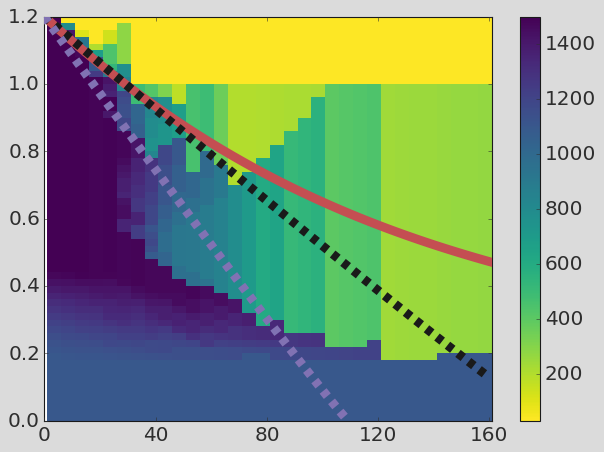

In [174]:
dx, dy = 1, 0.01
dx, dy = 5, 0.02
# dx, dy = 40, 0.4

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Approx\nThreshold'); 
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, color='k', linestyle='--', label = 'New\nThreshold');
ax.plot(tau_values, updated_n_stars, linewidth = 8, zorder=5, color='m', linestyle='--', label = 'Updated\nThreshold');

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold3"); plt.show()


To improve accuracy, use the S(t) at the TTP? Or better still, update it over time (using the mean of first and last time for each cycle.)

At the moment we are using the stem population at a fixed time (1000 days) which should underestimate the N_star value when the TTp is much less than this. This explains success beyond the critical threshold, but not premature progression before the threshold.

Maybe I need to check the accuracy of the S prediction?